### Installing dependencies for preprocessing of images 

In [1]:
!pip install imutils


### Adding the necessary functions and importing the required packages

In [2]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

 

Importing models and functions from keras and tensorflow

In [4]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.utils import shuffle

Importing the dataset

In [3]:
import imutils
!rm -rf capstone
!git clone https://github.com/suhas9897/capstone.git 

Cloning into 'capstone'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


Unzipping the dataset file cloned from Github

In [5]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/capstone/archive (6).zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/capstone') #Extracts the files into the /tmp folder
zip_ref.close()

## Data Preprocessing : Augmentation of images 

Since there are only few images in the dataset,data augmentation is done 

In [12]:
def augment_data(dir_file, sample_count, save_to_dir):
    generator = ImageDataGenerator(rotation_range=12, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  preprocessing_function=preprocess_input
                                 )

    for filename in listdir(dir_file):
        image = cv2.imread(dir_file + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in generator.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > sample_count:
                    break

### Making directory for augmented images

In [13]:
image_dir= '/content/capstone/brain_tumor_dataset/'
!rm -rf '../content/capstone/a_images'
os.makedirs('../content/capstone/a_images')
os.makedirs('../content/capstone/a_images/yes')
os.makedirs('../content/capstone/a_images/no')

In [19]:
augmented_data_path ='/content/capstone/a_images/'
augment_data(dir_file=image_dir+'yes',sample_count=7, save_to_dir=augmented_data_path+'yes')
augment_data(dir_file=image_dir+'no',sample_count=10, save_to_dir=augmented_data_path+'no')

## Data Preprocessing : Cropping Images

In [23]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    threshold_val = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_val = cv2.erode(threshold_val, None, iterations=2)
    threshold_val = cv2.dilate(threshold_val, None, iterations=2)

    contour = cv2.findContours(threshold_val.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)
  
    left_val = tuple(c[c[:, :, 0].argmin()][0])
    right_val = tuple(c[c[:, :, 0].argmax()][0])
    top_val = tuple(c[c[:, :, 1].argmin()][0])
    bottom_val = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[top_val[1]:bottom_val[1], left_val[0]:right_val[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

## After applying the cropping function

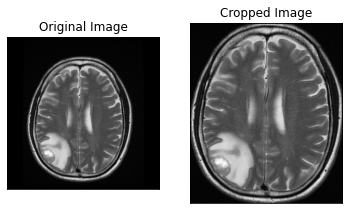

In [25]:
original_image = cv2.imread(image_dir+'yes/Y107.jpg')
cropped_image = crop_brain_contour(original_image, True)

##Loading the data

In [26]:
def dataset_loading(dir_list, image_size):

    X = []
    y = []
 
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
         
            tumour_image = cv2.imread(directory+'/'+filename)
            tumour_image = crop_brain_contour(tumour_image, plot=False)
            tumour_image = cv2.resize(tumour_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            tumour_image = tumour_image / 255.
            X.append(tumour_image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [27]:
augmented_with_tumour =augmented_data_path+'yes'
augmented_without_tumour = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = dataset_loading([augmented_with_tumour, augmented_without_tumour], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2316
X shape is: (2316, 240, 240, 3)
y shape is: (2316, 1)


## Visualization of data

In [28]:
def sample_images(X, y, n=40):
    for label in [0,1]:
       
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1      
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
       
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

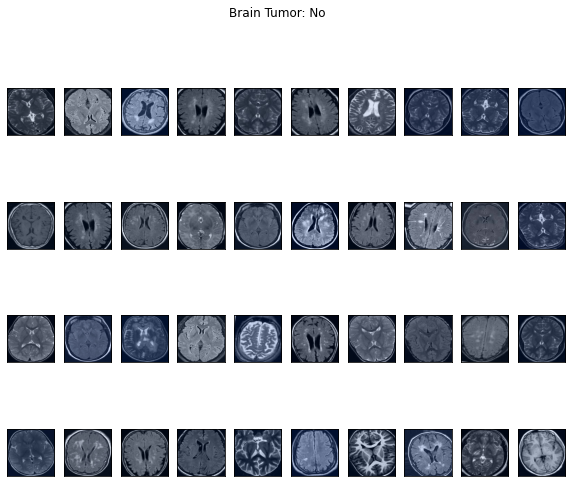

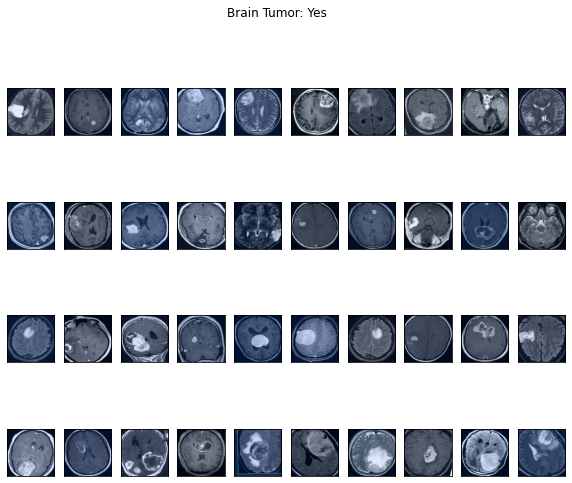

In [29]:
sample_images(X, y)

##Splitting the data into training, testing and validation sets

In [30]:
def data_split(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, y, test_size=0.3)

In [32]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1621
number of validation examples = 348
number of test examples = 347


##Building CNN model

In [36]:
def model_1(input_shape):
    
    X_input = Input(input_shape) 
   
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

##Keras model to point form

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 244, 244, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_1 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                       

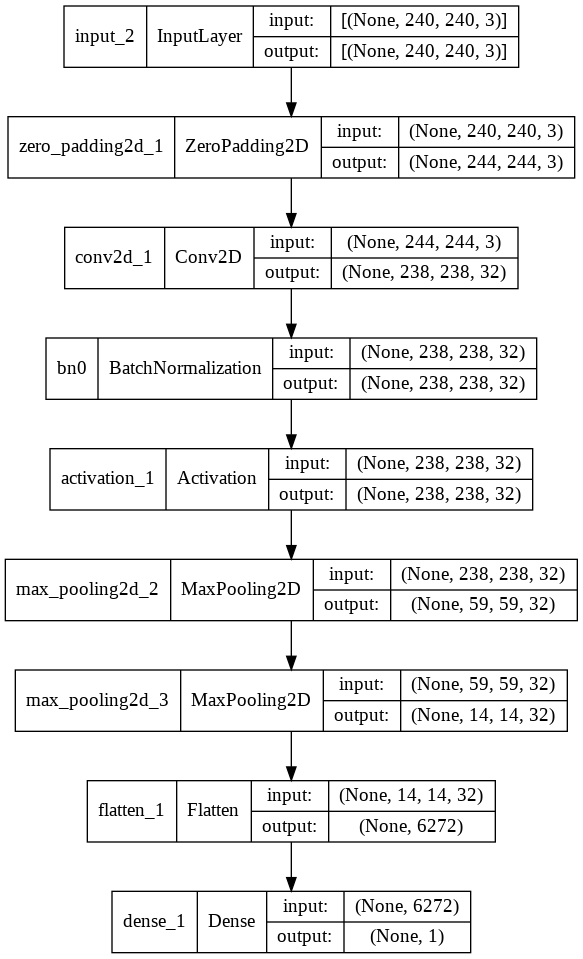

In [37]:
from keras import models
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=model_1(IMG_SHAPE)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


##Running the model and calculating accuracy and loss

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
51/51 [==============================] - 146s 3s/step - loss: 0.9793 - accuracy: 0.6015 - val_loss: 0.6714 - val_accuracy: 0.5632
Epoch 2/22
51/51 [==============================] - 145s 3s/step - loss: 0.5494 - accuracy: 0.7335 - val_loss: 0.6352 - val_accuracy: 0.5776
Epoch 3/22
51/51 [==============================] - 147s 3s/step - loss: 0.5143 - accuracy: 0.7557 - val_loss: 0.5779 - val_accuracy: 0.7759
Epoch 4/22
51/51 [==============================] - 159s 3s/step - loss: 0.4542 - accuracy: 0.7933 - val_loss: 0.5470 - val_accuracy: 0.7586
Epoch 5/22
51/51 [==============================] - 155s 3s/step - loss: 0.3783 - accuracy: 0.8341 - val_loss: 0.5431 - val_accuracy: 0.6868
Epoch 6/22
51/51 [==============================] - 150s 3s/step - loss: 0.3440 - accuracy: 0.8587 - val_loss: 0.4663 - val_accuracy: 0.7960
Epoch 7/22
51/51 [==============================] - 149s 3s/step - loss: 0.3366 - accuracy: 0.8507 - val_loss: 0.4863 - val_accuracy: 0.7845
Epoch 8/22
51

In [39]:
history = model.history.history

### Plotting of aaccuracy

In [40]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

In [42]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    plt.figure()

    # Loss
    

    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
   
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
 
    plt.show()

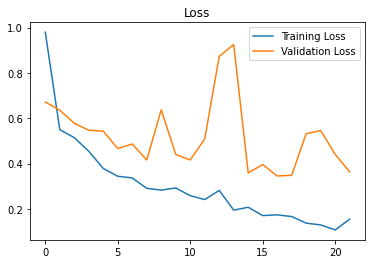

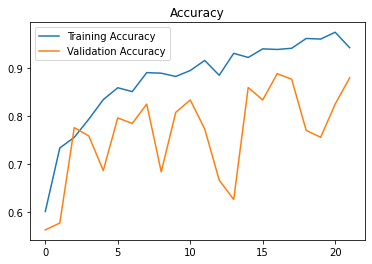

In [43]:
plot_metrics(history)

In [44]:
model.metrics_names

['loss', 'accuracy']

In [45]:
loss, acc = model.evaluate(x=X_test, y=y_test)

11/11 [==============================] - 8s 695ms/step - loss: 0.3676 - accuracy: 0.8501


##Calculating accuracy, loss and F1 scores

In [46]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.367617130279541
Test Accuracy = 0.85014408826828


In [47]:
y_test_prob = model.predict(X_test)

In [48]:
def compute_f1_score(y_true, prob):
   
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [49]:
from sklearn.metrics import f1_score

In [50]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8571428571428571


In [51]:

y_val_prob = model.predict(X_val)

In [53]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")



F1 score: 0.888888888888889


In [54]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [55]:
data_percentage(y)

Number of examples: 2316
Percentage of positive examples: 53.49740932642487%, number of pos examples: 1239
Percentage of negative examples: 46.50259067357513%, number of neg examples: 1077


In [56]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1621
Percentage of positive examples: 53.48550277606416%, number of pos examples: 867
Percentage of negative examples: 46.51449722393584%, number of neg examples: 754
Validation Data:
Number of examples: 348
Percentage of positive examples: 55.45977011494253%, number of pos examples: 193
Percentage of negative examples: 44.54022988505747%, number of neg examples: 155
Testing Data:
Number of examples: 347
Percentage of positive examples: 51.585014409221905%, number of pos examples: 179
Percentage of negative examples: 48.414985590778095%, number of neg examples: 168
